In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from evaluation_functions import ensemble_evaluation_functions as eef

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate

from sunpy.coordinates.sun import carrington_rotation_time
import astropy.units as u

In [2]:
def read_brier_scores_file(year, event_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\forecast_evaluation\\brier_scores_{year}_{event_thresh}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_rank_hist_file(year):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\rank_analysis\\rank_hist_{year}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_ROC_scores_file(year, prob_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\forecast_evaluation\\roc_scores_{year}_{int(prob_thresh*10)}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')



In [3]:
year_list = np.arange(2009,2020)

CR_year_dict = {2009:np.arange(2079,2092),
                2010:np.arange(2092,2106),
                2011:np.arange(2106,2119),
                2012:np.arange(2119,2133),
                2013:np.arange(2133,2146),
                2014:np.arange(2146,2159),
                2015:np.arange(2159,2173),
                2016:np.arange(2173,2186),
                2017:np.arange(2186,2200),
                2018:np.arange(2200,2213),
                2019:np.arange(2213,2226)}

event_threshold = 500
probability_threshold = 0.5

rank_histogram_grids = [read_rank_hist_file(year) for year in year_list]
briers_scores_grids = [read_brier_scores_file(year, event_threshold) for year in year_list]
ROC_scores_grids = [read_ROC_scores_file(year, probability_threshold) for year in year_list]

In [4]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

In [5]:
def compute_recurrence_BS(CR_chunk, omni_data, BS_thresh):

    forecast_window = 27.2753*u.day
    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:

        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(forecast_window.value, unit = 'days')
        data_chunks.append(omni_data.loc[CR_start:CR_end])

    # combining data frame will be useful later on
    combined_data = pd.concat(data_chunks)

    ## Define carrington rotation offset for index
    carrington_rotation = pd.Timedelta(27.25, unit = 'days')
    omni_data_reccurance = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

    # Isolate data within forecast range + backward additional month needed for 1st carrington rotations of forecast
    omni_data_reccurance = omni_data_reccurance.loc[(combined_data.index[0]-carrington_rotation):combined_data.index[-1]]

    # Grab index from isolated reccurence data set
    omni_data_index = omni_data_reccurance.index

    # Project index forward by 1 carrington rotation
    reccurance_forecast_index = omni_data_index + carrington_rotation

    # Set index for reccurent forecast to the new forward projected datetime series
    reccurance_forecast = omni_data_reccurance.set_index(reccurance_forecast_index)
    reccurance_forecast = reccurance_forecast.loc[pd.to_datetime(combined_data.index[0]):pd.to_datetime(combined_data.index[-1])]

    rec_BS = eef.compute_brier_score(forecast=reccurance_forecast['V'], observed_data=combined_data['V'], threshold=BS_thresh)

    return rec_BS

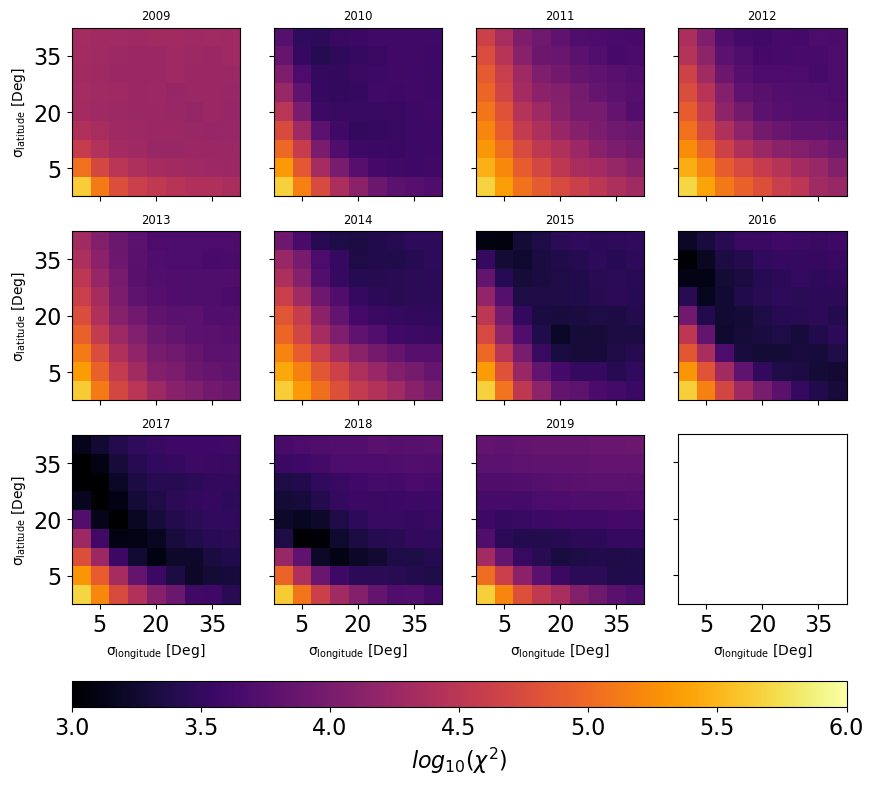

In [6]:
fig, axes = plt.subplots(ncols = 4, nrows = 3, figsize = (10,10), sharex = True, sharey = True)
axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

for i in range(len(year_list)):

    year = year_list[i]
    rank_hist = rank_histogram_grids[i]
    CR_chunk = CR_year_dict[year]

    im = axes[i].imshow(np.log10(rank_hist), cmap='inferno', origin = 'lower', vmin = 3, vmax = 6) 
    axes[i].set_title(f'{year}', fontsize = 'small')

outer_y_index = [0,4,8]
for y in outer_y_index:
    axes[y].set_yticks(np.arange(len(lat_dev_list))[1::3])
    axes[y].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
    axes[y].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = np.arange(8,12,1)
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'$log_{{10}}(\chi^2)$')

#fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\chisquaredsolarcycle.svg"
#plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
#plt.tight_layout()
plt.show()

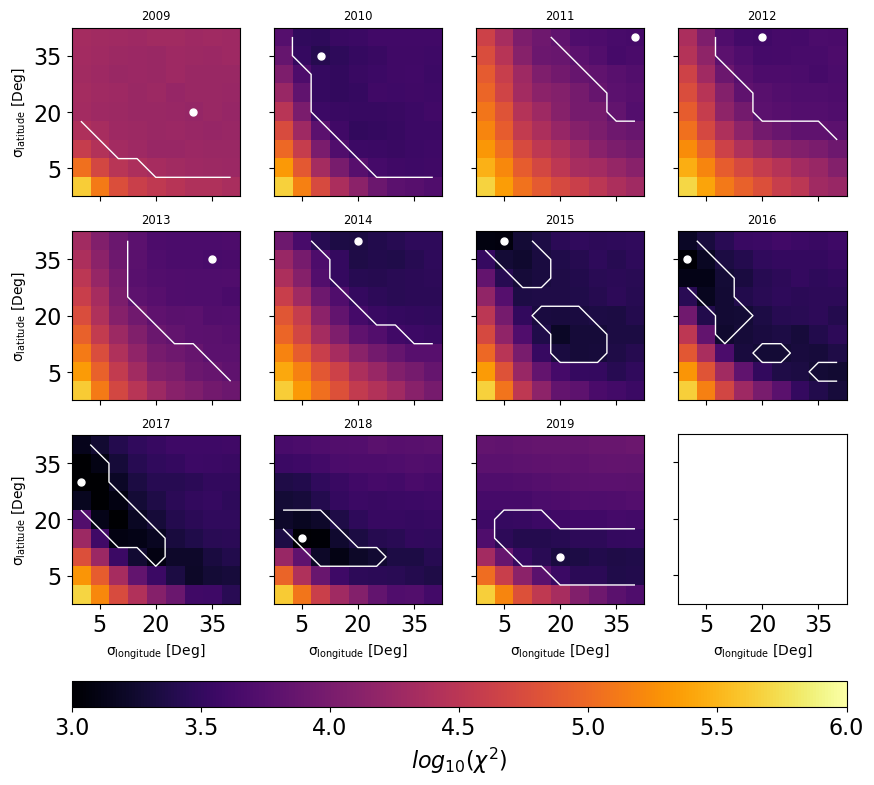

In [7]:
fig, axes = plt.subplots(ncols = 4, nrows = 3, figsize = (10,10), sharex = True, sharey = True)
axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

for i in range(len(year_list)):

    year = year_list[i]
    rank_hist = rank_histogram_grids[i]
    CR_chunk = CR_year_dict[year]

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_5percent_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.1
    mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]

    im = axes[i].imshow(np.log10(rank_hist), cmap='inferno', origin = 'lower', vmin = 3, vmax = 6) 
    contours = axes[i].contour(within_5percent_of_min, levels = [0.5], colors='white', corner_mask = False, linewidths=1, label = r'$\mathrm{5^th percentile range}$')
    axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'white')
    axes[i].set_title(f'{year}', fontsize = 'small')

outer_y_index = [0,4,8]
for y in outer_y_index:
    axes[y].set_yticks(np.arange(len(lat_dev_list))[1::3])
    axes[y].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
    axes[y].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = np.arange(8,12,1)
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'$log_{{10}}(\chi^2)$')
#fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\chisquaredsolarcycle_withbounds.svg"
#plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
#plt.tight_layout()
plt.show()

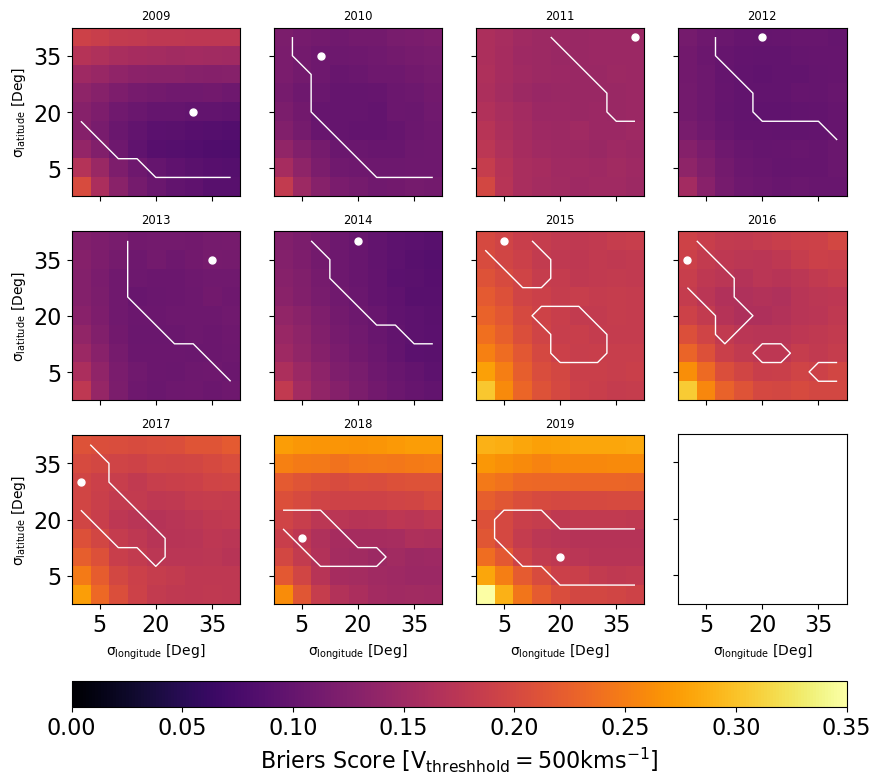

In [33]:
fig, axes = plt.subplots(ncols = 4, nrows = 3, figsize = (10,10), sharex = True, sharey = True)
axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

for i in range(len(year_list)):

    year = year_list[i]
    briers_grid = briers_scores_grids[i]
    rank_hist = rank_histogram_grids[i]

    CR_chunk = CR_year_dict[year]

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_percentile_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.1
    mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]

    im = axes[i].imshow(briers_grid, cmap='inferno', origin = 'lower', vmin = 0, vmax = 0.35) 
    contours = axes[i].contour(within_percentile_of_min, levels = [0.5], colors='white', corner_mask = False, linewidths=1, label = r'$\mathrm{5^th percentile range}$')
    axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'white')
    axes[i].set_title(f'{year}', fontsize = 'small')

outer_y_index = [0,4,8]
for y in outer_y_index:
    axes[y].set_yticks(np.arange(len(lat_dev_list))[1::3])
    axes[y].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
    axes[y].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = np.arange(8,12,1)
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'Briers Score [$\mathrm{{V_{{threshhold}} = {event_threshold}kms^{{-1}}}}$]')

#fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\brierscoresolarcycle_withbounds.svg"
#plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
#plt.tight_layout()
plt.show()

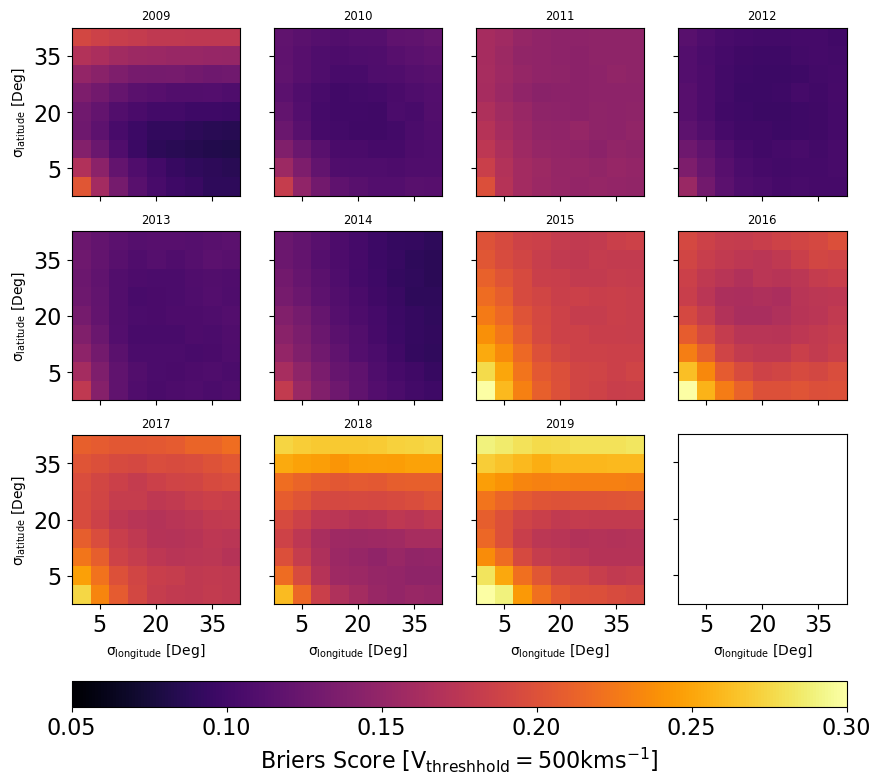

In [9]:
fig, axes = plt.subplots(ncols = 4, nrows = 3, figsize = (10,10), sharex = True, sharey = True)
axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

for i in range(len(year_list)):

    year = year_list[i]
    briers_grid = briers_scores_grids[i]
    CR_chunk = CR_year_dict[year]

    grid_range = np.max(briers_grid) - np.min(briers_grid)
    within_percentile_of_min = briers_grid < np.min(briers_grid) + grid_range*0.1
    mindex = np.argwhere(briers_grid == np.min(briers_grid))[0]

    im = axes[i].imshow(briers_grid, cmap='inferno', origin = 'lower', vmin = 0.05, vmax = 0.3) 
    #contours = axes[i].contour(within_percentile_of_min, levels = [0.5], colors='white', corner_mask = False, linewidths=1, label = r'$\mathrm{5^th percentile range}$')
    #axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'white')
    axes[i].set_title(f'{year}', fontsize = 'small')

outer_y_index = [0,4,8]
for y in outer_y_index:
    axes[y].set_yticks(np.arange(len(lat_dev_list))[1::3])
    axes[y].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
    axes[y].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = np.arange(8,12,1)
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'Briers Score [$\mathrm{{V_{{threshhold}} = {event_threshold}kms^{{-1}}}}$]')


#fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\briersscoresolarcycle.svg"
#plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
#plt.tight_layout()
plt.show()

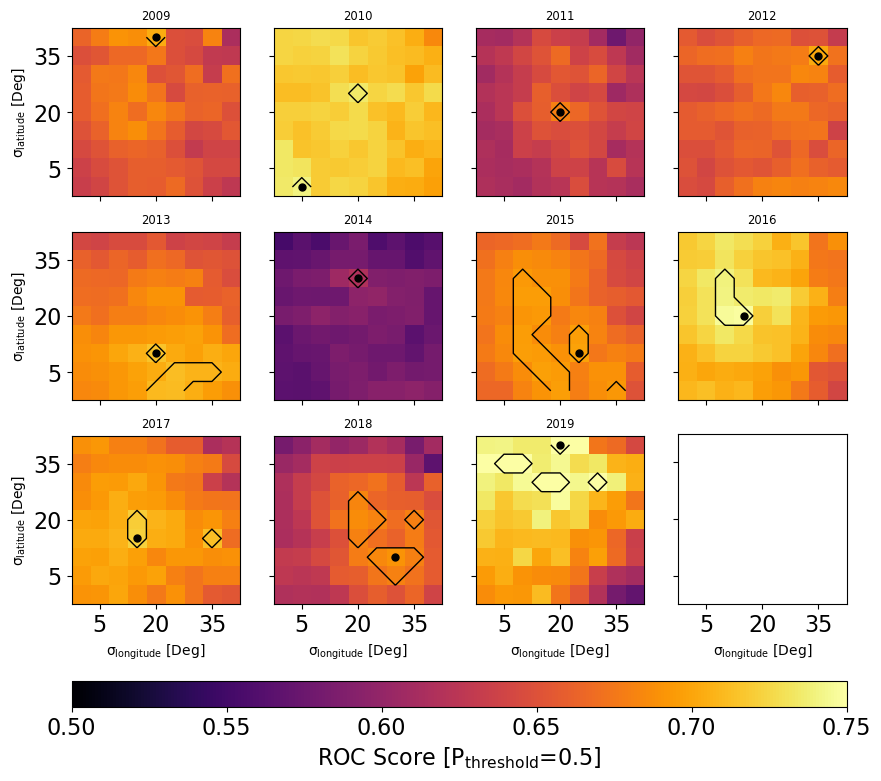

In [8]:
fig, axes = plt.subplots(ncols = 4, nrows = 3, figsize = (10,10), sharex = True, sharey = True)
axes = axes.flatten()

#fig.suptitle(f'ROC score distributions $\mathrm{{P_{{threshold}}}}$={probability_threshold}')
lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

for i in range(len(year_list)):

    year = year_list[i]
    roc_grid = ROC_scores_grids[i]
    CR_chunk = CR_year_dict[year]

    im = axes[i].imshow(roc_grid, cmap='inferno', origin = 'lower', vmin = 0.5, vmax = 0.75) 
    axes[i].set_title(f'{year}', fontsize = 'small')

    grid_range = np.max(roc_grid) - np.min(roc_grid)
    within_percentile_of_min = roc_grid > np.max(roc_grid) - grid_range*0.1
    mindex = np.argwhere(roc_grid == np.max(roc_grid))[0]
    contours = axes[i].contour(within_percentile_of_min, levels = [0.5], colors='black',corner_mask = False, linewidths=1, label = r'$\mathrm{5^th percentile range}$')
    axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'black')
    

outer_y_index = [0,4,8]
for y in outer_y_index:
    axes[y].set_yticks(np.arange(len(lat_dev_list))[1::3])
    axes[y].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
    axes[y].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = np.arange(8,12,1)
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'ROC Score [$\mathrm{{P_{{threshold}}}}$={probability_threshold}]')

#plt.tight_layout()
plt.show()

Brier Skill Score (BSS) where the reference score $\mathrm{BS_{ref}=BS_{rec}}$ such that $\mathrm{BSS~=~1~-\frac{BS_{ensemble}}{BS_{recurrence}}}$

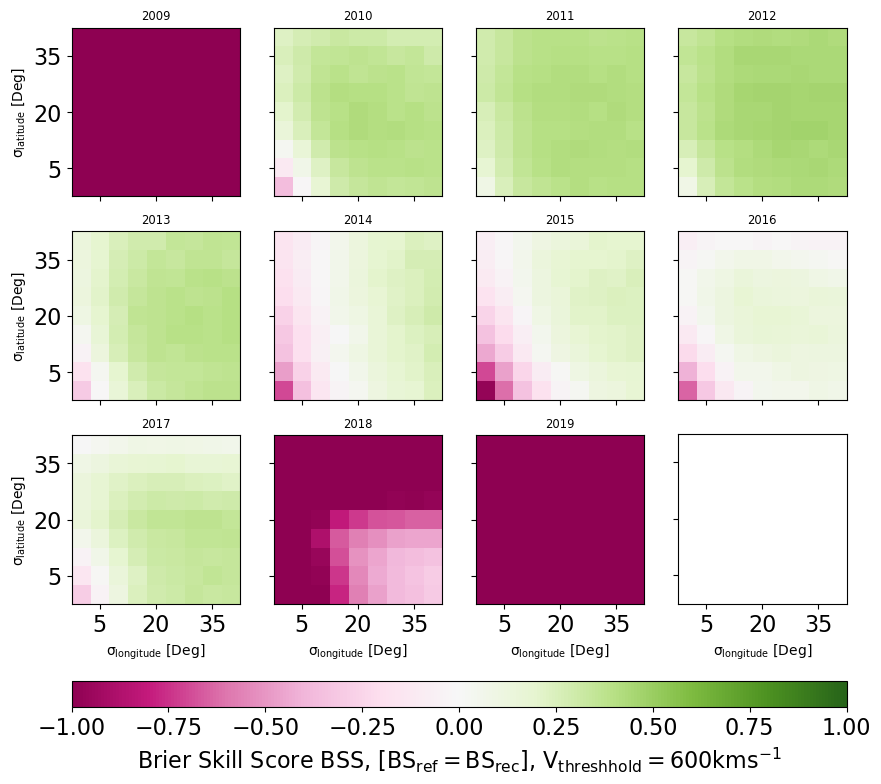

In [19]:
fig, axes = plt.subplots(ncols = 4, nrows = 3, figsize = (10,10), sharex = True, sharey = True)
axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

for i in range(len(year_list)):

    year = year_list[i]
    briers_grid = briers_scores_grids[i]
    CR_chunk = CR_year_dict[year]
    rec_BS = compute_recurrence_BS(CR_chunk=CR_chunk, omni_data=omni_data, BS_thresh=event_threshold)

    im = axes[i].imshow((1 - briers_grid/rec_BS), cmap='PiYG', origin = 'lower', vmin = -1, vmax = 1) 
    axes[i].set_title(f'{year}', fontsize = 'small')

outer_y_index = [0,4,8]
for y in outer_y_index:
    axes[y].set_yticks(np.arange(len(lat_dev_list))[1::3])
    axes[y].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
    axes[y].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = np.arange(8,12,1)
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'Brier Skill Score BSS, [$\mathrm{{BS_{{ref}}=BS_{{rec}}}}$], $\mathrm{{V_{{threshhold}} = {event_threshold}kms^{{-1}}}}$')

#plt.tight_layout()
plt.show()

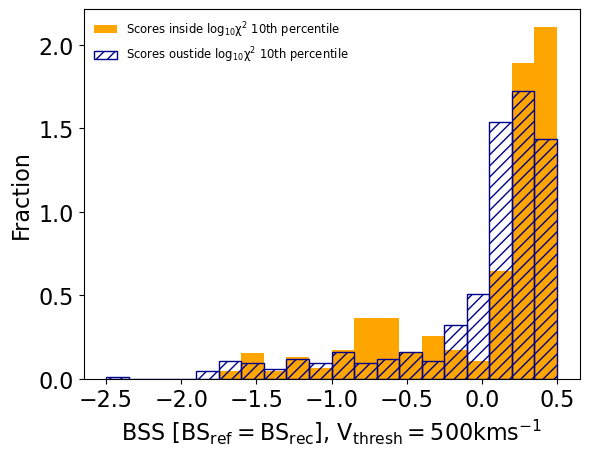

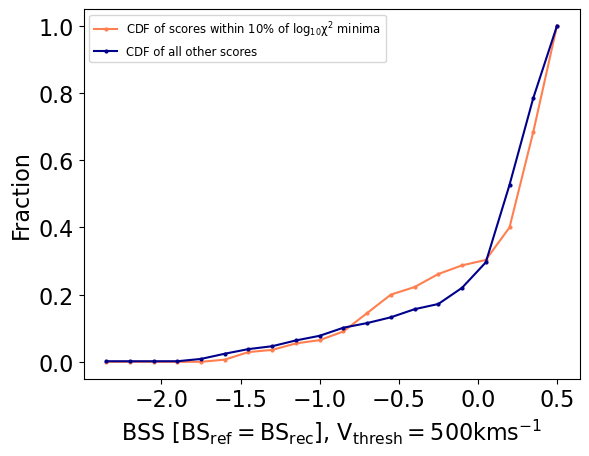

In [34]:
scores_within_bounds = []
scores_out_bounds = []

for i in range(len(year_list)):

    year = year_list[i]
    rank_hist = rank_histogram_grids[i]
    briers_grid = briers_scores_grids[i]
    CR_chunk = CR_year_dict[year]
    rec_BS = compute_recurrence_BS(CR_chunk=CR_chunk, omni_data=omni_data, BS_thresh=event_threshold)

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_percentile_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.1

    scores_within_bounds.append((1-briers_grid/rec_BS)[within_percentile_of_min])
    scores_out_bounds.append((1-briers_grid/rec_BS)[~within_percentile_of_min])

scores_within_bounds = np.concatenate(scores_within_bounds)
scores_out_bounds = np.concatenate(scores_out_bounds)


bins = np.linspace(-2.5,0.5,21)
plt.hist(scores_within_bounds, label = r'Scores inside $\mathrm{\log_{10}{\chi^2}}$ 10th percentile', density=True, bins = bins, color = 'orange')
plt.hist(scores_out_bounds, label = r'Scores oustide $\mathrm{\log_{10}{\chi^2}}$ 10th percentile', density=True, bins = bins, fill = False, edgecolor = 'darkblue', hatch = '///')
plt.legend(frameon = False, fontsize = 'small')
plt.xlabel(f'BSS [$\mathrm{{BS_{{ref}}=BS_{{rec}}}}$], $\mathrm{{V_{{thresh}} = {event_threshold}kms^{{-1}}}}$')
plt.ylabel('Fraction')
plt.show()


### Computing CDF for briers scores within/without briers minima bounds
hist_1, bin_edges_1 = np.histogram(scores_within_bounds, bins = bins, normed = True)
dx = bin_edges_1[1] - bin_edges_1[0]
F1 = np.cumsum(hist_1)*dx

hist_2, bin_edges_2 = np.histogram(scores_out_bounds, bins = bins, normed = True)
dx = bin_edges_2[1] - bin_edges_2[0]
F2 = np.cumsum(hist_2)*dx

plt.plot(bin_edges_1[1:], F1, marker = 'o', markersize = 2, label = r'CDF of scores within 10% of $\mathrm{\log_{10}{\chi^2}}$ minima', color = 'coral')
plt.plot(bin_edges_2[1:], F2, marker = 'o', markersize = 2, label = r'CDF of all other scores', color = 'darkblue')
plt.legend(fontsize = 'small')
plt.xlabel(f'BSS [$\mathrm{{BS_{{ref}}=BS_{{rec}}}}$], $\mathrm{{V_{{thresh}} = {event_threshold}kms^{{-1}}}}$')
plt.ylabel('Fraction')
plt.show()

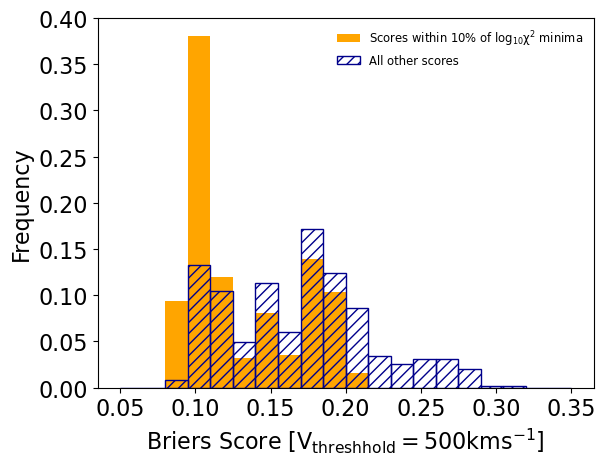

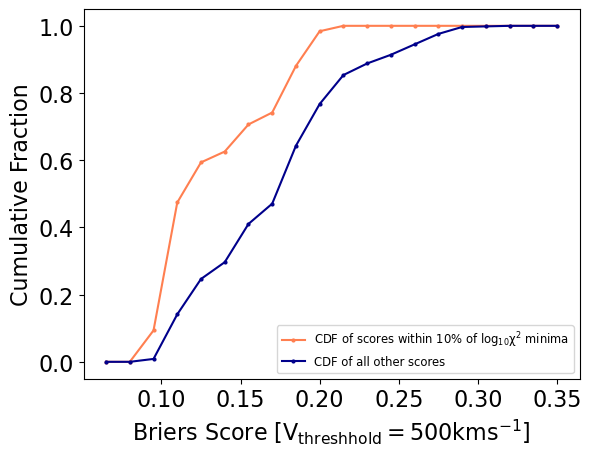

In [29]:
scores_within_bounds = []
scores_out_bounds = []

for i in range(len(year_list)):

    year = year_list[i]
    rank_hist = rank_histogram_grids[i]
    brier_grid = briers_scores_grids[i]
    CR_chunk = CR_year_dict[year]

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_percentile_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.1
    mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]

    scores_within_bounds.append(brier_grid[within_percentile_of_min])
    scores_out_bounds.append(brier_grid[~within_percentile_of_min])

scores_within_bounds = np.concatenate(scores_within_bounds)
scores_out_bounds = np.concatenate(scores_out_bounds)


bins = np.linspace(0.05,0.35,21)
plt.hist(scores_within_bounds, label = r'Scores within 10% of $\mathrm{\log_{10}{\chi^2}}$ minima', 
         weights=np.ones(len(scores_within_bounds))/len(scores_within_bounds), bins = bins, color = 'orange')
plt.hist(scores_out_bounds, label = 'All other scores', weights=np.ones(len(scores_out_bounds))/len(scores_out_bounds), bins = bins, fill = False, edgecolor = 'darkblue', hatch = '///')
# plt.hist(np.concatenate(briers_scores_grids).flatten(), label = 'All scores', 
#         weights=np.ones(len(np.concatenate(briers_scores_grids).flatten()))/len(np.concatenate(briers_scores_grids).flatten()), bins = bins, fill = True, edgecolor = 'cornflowerblue', hatch = '//', alpha = 0.3)
plt.legend(frameon = False, fontsize = 'small')
plt.xlabel(f'Briers Score [$\mathrm{{V_{{threshhold}} = {event_threshold}kms^{{-1}}}}$]')
plt.ylabel('Frequency')
plt.ylim(0, 0.4)

#fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\brierscores_distribution.svg"
#plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
plt.show()



### Computing CDF for briers scores within/without briers minima bounds
hist_1, bin_edges_1 = np.histogram(scores_within_bounds, bins = bins, normed = True)
dx1 = bin_edges_1[1] - bin_edges_1[0]
F1 = np.cumsum(hist_1)*dx1

hist_2, bin_edges_2 = np.histogram(scores_out_bounds, bins = bins, normed = True)
dx2 = bin_edges_2[1] - bin_edges_2[0]
F2 = np.cumsum(hist_2)*dx2

hist_tot, bin_edges_tot = np.histogram(briers_scores_grids, bins = bins, normed = True)
dx_tot = bin_edges_tot[1] - bin_edges_tot[0]
Ftot = np.cumsum(hist_tot)*dx_tot

plt.plot(bin_edges_1[1:], F1, marker = 'o', markersize = 2, label = r'CDF of scores within 10% of $\mathrm{\log_{10}{\chi^2}}$ minima', color = 'coral')
plt.plot(bin_edges_2[1:], F2, marker = 'o', markersize = 2, label = r'CDF of all other scores', color = 'darkblue')
plt.legend(fontsize = 'small')
plt.xlabel(f'Briers Score [$\mathrm{{V_{{threshhold}} = {event_threshold}kms^{{-1}}}}$]')
plt.ylabel('Cumulative Fraction')
#fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\brierscores_CDF.svg"
#plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
plt.show()

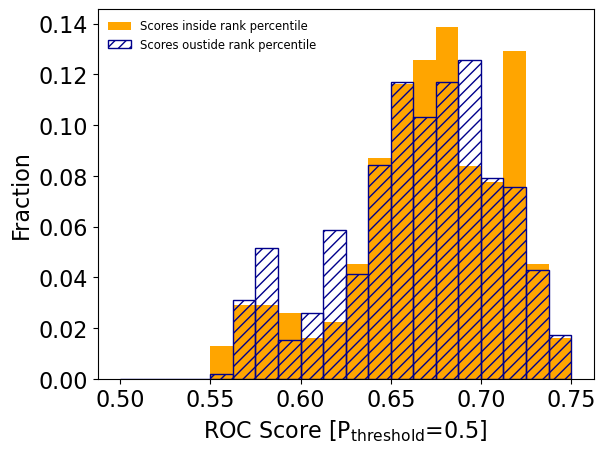

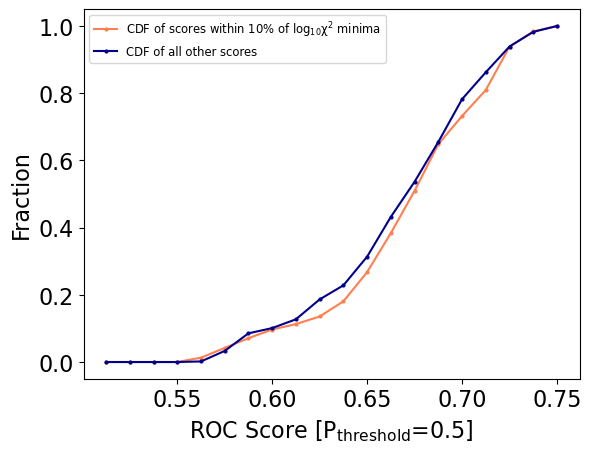

In [31]:
scores_within_bounds = []
scores_out_bounds = []

for i in range(len(year_list)):

    year = year_list[i]
    rank_hist = rank_histogram_grids[i]
    roc_grid = ROC_scores_grids[i]
    CR_chunk = CR_year_dict[year]

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_percentile_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.1
    mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]

    scores_within_bounds.append(roc_grid[within_percentile_of_min])
    scores_out_bounds.append(roc_grid[~within_percentile_of_min])

scores_within_bounds = np.concatenate(scores_within_bounds)
scores_out_bounds = np.concatenate(scores_out_bounds)

bins = np.linspace(0.5,0.75,21)
plt.hist(scores_within_bounds, label = 'Scores inside rank percentile', 
         weights=np.ones(len(scores_within_bounds))/len(scores_within_bounds), bins = bins, color = 'orange')
plt.hist(scores_out_bounds, label = 'Scores oustide rank percentile', 
         weights=np.ones(len(scores_out_bounds))/len(scores_out_bounds), bins = bins, fill = False, edgecolor = 'darkblue', hatch = '///')
plt.legend(frameon = False, fontsize = 'small')
plt.xlabel(f'ROC Score [$\mathrm{{P_{{threshold}}}}$={probability_threshold}]')
plt.ylabel('Fraction')
fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\ROC_briers.svg"
plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
plt.show()

### Computing CDF for briers scores within/without briers minima bounds
hist_1, bin_edges_1 = np.histogram(scores_within_bounds, bins = bins, normed = True)
dx = bin_edges_1[1] - bin_edges_1[0]
F1 = np.cumsum(hist_1)*dx

hist_2, bin_edges_2 = np.histogram(scores_out_bounds, bins = bins, normed = True)
dx = bin_edges_2[1] - bin_edges_2[0]
F2 = np.cumsum(hist_2)*dx

plt.plot(bin_edges_1[1:], F1, marker = 'o', markersize = 2, label = r'CDF of scores within 10% of $\mathrm{\log_{10}{\chi^2}}$ minima', color = 'coral')
plt.plot(bin_edges_2[1:], F2, marker = 'o', markersize = 2, label = r'CDF of all other scores', color = 'darkblue')
plt.legend(fontsize = 'small')
plt.xlabel(f'ROC Score [$\mathrm{{P_{{threshold}}}}$={probability_threshold}]')
plt.ylabel('Fraction')
fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\ROC_CDF.svg"
plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
plt.show()

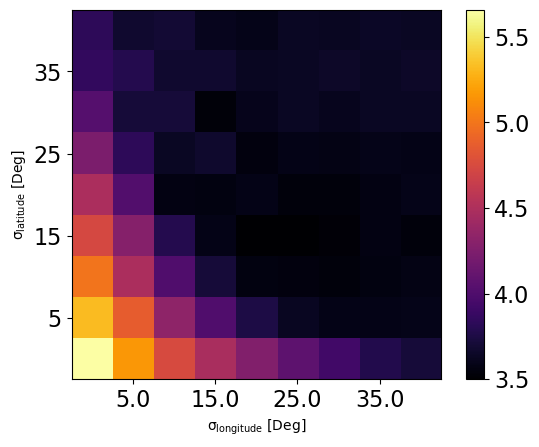

In [13]:
event_threshold = 550
probability_threshold = 0.5

rank_histogram_grids = [read_rank_hist_file(year) for year in year_list]
briers_scores_grids = [read_brier_scores_file(year, event_threshold) for year in year_list]
ROC_scores_grids = [read_ROC_scores_file(year, probability_threshold) for year in year_list]

im = plt.imshow((np.median(np.log10(rank_histogram_grids), axis = 0)), cmap='inferno', origin = 'lower')

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

plt.xticks(np.arange(len(long_dev_list))[1::2], long_dev_list[1::2])
plt.yticks(np.arange(len(lat_dev_list))[1::2], lat_dev_list[1::2])

plt.xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
plt.ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')

plt.colorbar()

plt.show()



In [15]:
percentile_masks = []
for i in range(len(year_list)):

    year = year_list[i]
    briers_grid = briers_scores_grids[i]
    CR_chunk = CR_year_dict[year]

    grid_range = np.max(briers_grid) - np.min(briers_grid)
    within_percentile_of_min = briers_grid < np.min(briers_grid) + grid_range*0.1
    percentile_masks.append(within_percentile_of_min)

percentile_masks_rank = []
for i in range(len(year_list)):

    year = year_list[i]
    rank_hist = rank_histogram_grids[i]
    briers_grid = briers_scores_grids[i]
    CR_chunk = CR_year_dict[year]

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_percentile_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.1
    percentile_masks_rank.append(within_percentile_of_min)

percentile_masks_ROC = []
for i in range(len(year_list)):

    year = year_list[i]
    rank_hist = rank_histogram_grids[i]
    ROC_grid = ROC_scores_grids[i]
    CR_chunk = CR_year_dict[year]

    grid_range = np.max(ROC_grid) - np.min(ROC_grid)
    within_percentile_of_min = ROC_grid > np.max(ROC_grid) - grid_range*0.1
    percentile_masks_ROC.append(within_percentile_of_min)

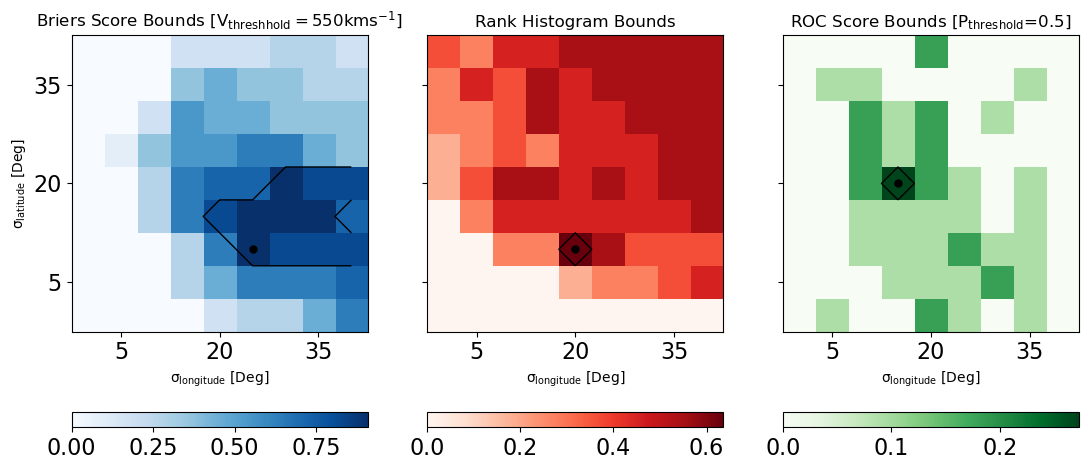

In [16]:
fig, axes = plt.subplots(ncols = 3, nrows=1, sharey=True, figsize = (13,7))

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

im1 = axes[0].imshow(np.mean(percentile_masks, axis = 0), cmap = 'Blues', origin = 'lower')
grid_range = np.max(np.mean(percentile_masks, axis = 0)) - np.min(np.mean(percentile_masks, axis = 0))
within_percentile_of_max = np.mean(percentile_masks, axis = 0) > np.max(np.mean(percentile_masks, axis = 0))- grid_range*0.1
mindex = np.argwhere(np.mean(percentile_masks, axis = 0) == np.max(np.mean(percentile_masks, axis = 0)))[0]
contours = axes[0].contour(within_percentile_of_max, levels = [0.5], colors='black', corner_mask = False, linewidths=1, label = r'$\mathrm{10^th percentile range}$')
axes[0].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'black')

im2 = axes[1].imshow(np.mean(percentile_masks_rank, axis = 0), cmap = 'Reds', origin = 'lower')
grid_range = np.max(np.mean(percentile_masks_rank, axis = 0)) - np.min(np.mean(percentile_masks_rank, axis = 0))
within_percentile_of_max = np.mean(percentile_masks_rank, axis = 0) > np.max(np.mean(percentile_masks_rank, axis = 0))- grid_range*0.1
mindex = np.argwhere(np.mean(percentile_masks_rank, axis = 0) == np.max(np.mean(percentile_masks_rank, axis = 0)))[0]
contours = axes[1].contour(within_percentile_of_max, levels = [0.5], colors='black', corner_mask = False, linewidths=1, label = r'$\mathrm{10^th percentile range}$')
axes[1].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'black')

im3 = axes[2].imshow(np.mean(percentile_masks_ROC, axis = 0), cmap = 'Greens', origin = 'lower')
grid_range = np.max(np.mean(percentile_masks_ROC, axis = 0)) - np.min(np.mean(percentile_masks_ROC, axis = 0))
within_percentile_of_max = np.mean(percentile_masks_ROC, axis = 0) > np.max(np.mean(percentile_masks_ROC, axis = 0))- grid_range*0.1
mindex = np.argwhere(np.mean(percentile_masks_ROC, axis = 0) == np.max(np.mean(percentile_masks_ROC, axis = 0)))[0]
contours = axes[2].contour(within_percentile_of_max, levels = [0.5], colors='black', corner_mask = False, linewidths=1, label = r'$\mathrm{10^th percentile range}$')
axes[2].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'black')

axes[0].set_xticks(np.arange(len(long_dev_list))[1::3])
axes[0].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
axes[0].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
axes[0].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)
axes[0].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[0].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])
axes[0].set_title(f'Briers Score Bounds [$\mathrm{{V_{{threshhold}} = {event_threshold}kms^{{-1}}}}$]')

axes[1].set_xticks(np.arange(len(long_dev_list))[1::3])
axes[1].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
axes[1].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)
axes[1].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[1].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])
axes[1].set_title('Rank Histogram Bounds')

axes[2].set_xticks(np.arange(len(long_dev_list))[1::3])
axes[2].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
axes[2].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)
axes[2].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[2].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])
axes[2].set_title(f'ROC Score Bounds [$\mathrm{{P_{{threshold}}}}$={probability_threshold}]')

fig.colorbar(im1, ax=axes[0], orientation = 'horizontal', pad = 0.15)
fig.colorbar(im2, ax=axes[1], orientation = 'horizontal', pad = 0.15)
fig.colorbar(im3, ax=axes[2], orientation = 'horizontal', pad = 0.15)

plt.show()

### Calibration Curve

In [43]:
# perturbation parameters
lat_dev_list = np.linspace(0,40,9)
long_dev_list = np.linspace(0,40,9)

# finding associated lat/long parameters for minima in chi squared grid
min_index = np.argmin(rank_histogram_grids[2])
min_lat, min_long = (np.meshgrid(lat_dev_list, long_dev_list)[1].flatten()[min_index], 
np.meshgrid(lat_dev_list, long_dev_list)[0].flatten()[min_index])





40.0 40.0


In [ ]:
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy = 'quantile')